In [1]:
from SSVAERegressor import *
from SSVAERegressorX import *
import numpy as np
import util
from sklearn.preprocessing import  *
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

The quick idea is to build on the semi-supervised VAE-style method currently being used by Nao and Ayse. In that approach you treat one of the hidden VAE layer variables as y (the label) and then use the rest of the hidden VAE variables (called z) to encode the rest of the sample. The hope is that the unsupervised model will put all the label data into y, and all the information not related to the label in z. Then when doing the unsupervised part of training getting a good reconstruction will require also getting a good label y.

The idea above breaks down if z starts to also encode much of the label information, because then during reconstruction on unsupervised samples y can be wrong and you still get a good reconstruction. To help prevent this I was thinking you could use “domain confusion” to force z to not contain any information about the label y. This would essentially involve putting a second head on the network that is based only on z, and not y, which tries to predict the class label for labeled examples. The gradient is then flipped during the back prop right at the z variables (for gradients coming from the second head), this causes the VAE to try and prevent this second head from determining the class data y from the z variables. Again, the whole purpose is to force the label y to be critical in the reconstruction process so that unlabeled examples improve our prediction performance.

For more info on this style of domain confusion (which is really close to GAN’s) check out: http://www.jmlr.org/papers/volume17/15-239/15-239.pdf


In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000,784)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

train_unlabeled = util.BatchFeeder(X[index[:53000]], np.zeros((53000, 1)), 128)
train_labeled = util.BatchFeeder(X[index[53000:54000]], scale(np.argmax(Y[index[53000:54000]], axis=1).reshape((1000, 1))), 128)
test_data = (X[index[54000:]], scale(np.argmax(Y[index[54000:]], axis=1).reshape((1000, 1))))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


/home/hiranumn/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [3]:
std = np.std(np.argmax(Y[index[53000:54000]], axis=1))
m = np.mean(np.argmax(Y[index[53000:54000]], axis=1))

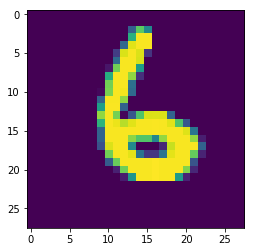

In [4]:
data = train_labeled.next()
plt.figure()
plt.imshow(data[0][0].reshape((28,28)))
plt.show()

# Extended VAE

In [5]:
model1 = SSVAERegressorX(input_dim=784, vae_dims=[256, 64], prediction_dim=1, reg_dims=[256,64], latent_dim=2)

Epoch: [499/500] loss: 270.13, kld: 11.43, rec: 256.41, logdensity(labeled): 1.24, kld(unlabeled): 2.41, mse: 0.1761

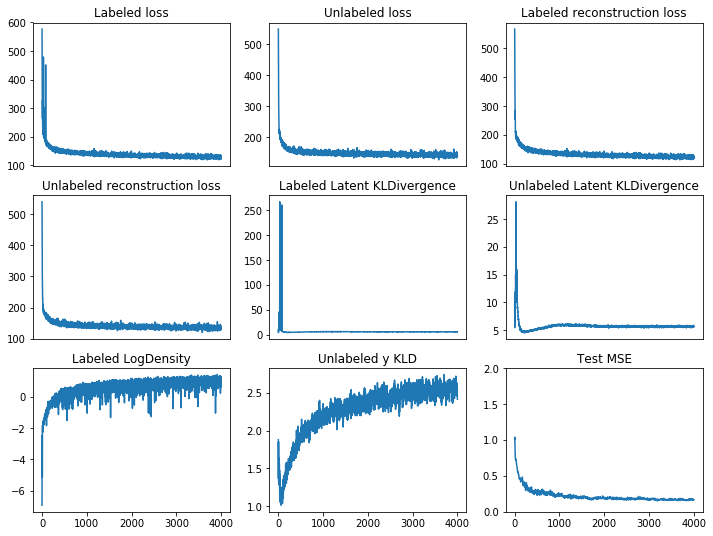

In [6]:
model1.train(train_labeled, train_unlabeled, epochs=500, valid=test_data)

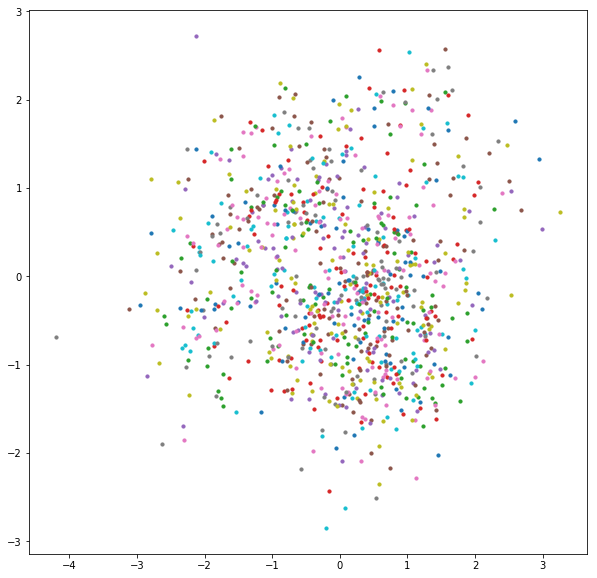

In [7]:
model = model1

plt.figure(figsize=(10,10))
for i in range(1,10):
    ys = (model.record["ys"][-1*i]*std+m).reshape((128,))
    mus = model.record["mus"][-1*i]
    for j in range(10):
        temp = mus[ys==j]
        plt.scatter(temp[:, 0], temp[:, 1], label=j, s=10)
plt.show()

# Regular SSVAE

In [8]:
model2 = SSVAERegressor(input_dim=784, vae_dims=[256, 64], prediction_dim=1, reg_dims=[256,64], latent_dim=2)

Epoch: [499/500] loss: 272.51, kld: 11.49, rec: 258.61, logdensity(labeled): 1.12, kld(unlabeled): 2.52, mse: 0.188

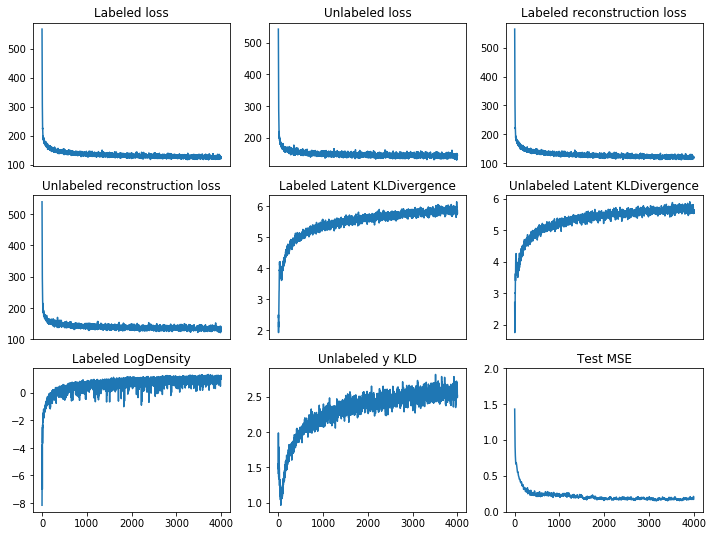

In [9]:
model2.train(train_labeled, train_unlabeled, epochs=500, valid=test_data)

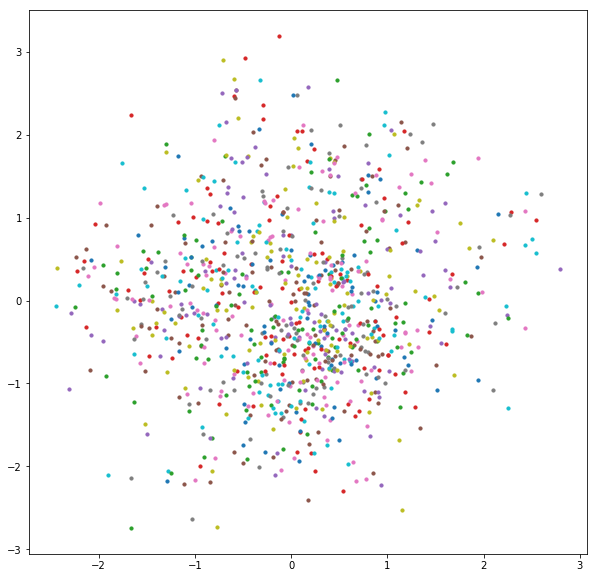

In [10]:
model = model2

plt.figure(figsize=(10,10))
for i in range(1,10):
    ys = (model.record["ys"][-1*i]*std+m).reshape((128,))
    mus = model.record["mus"][-1*i]
    for j in range(10):
        temp = mus[ys==j]
        plt.scatter(temp[:, 0], temp[:, 1], label=j, s=10)
plt.show()